# Analyses of CMAP '20

In this notebook we will analyse the most recent pre-release version of the CMAP L1000 dataset. We are interested in finding some genetic expression data for the different overexpression settings of our imaging-based study.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
from cmapPy.pandasGEXpress.parse import parse
import random
import umap
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

seed = 1234
np.random.seed(seed)
random.seed(1234)

%load_ext nb_black

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

----

## 1. Read in data

In [2]:
cmap_inst_info = pd.read_csv("/home/paysan_d/Downloads/instinfo_beta.txt", sep="\t")
cmap_inst_info.head()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_itime,pert_time_unit,cell_mfc_name,pert_mfc_id,...,sample_id,pert_type,cell_iname,qc_pass,dyn_range,inv_level_10,build_name,failure_mode,project_code,cmap_name
0,b11,NaN,20.00,uL,20 uL,72.0,72 h,h,VCAP,ERG_11,...,ERG013_VCAP_72H_X3_B11:O14,trt_sh,VCAP,0.0,4.20788,4220.5,NaN,dyn_range,ERG,ERG
1,b10,NaN,1.00,uL,1 uL,96.0,96 h,h,U2OS,TRCN0000072237,...,TAK004_U2OS_96H_X2_B10_DUO52HI53LO:D10,ctl_vector,U2OS,0.0,4.73906,1462.0,NaN,inv_level_10,TAK,LACZ
2,b12,NaN,0.10,ng/ml,0.1 ng/ml,2.0,2 h,h,HEPG2,SOD3,...,CYT001_HEPG2_2H_X2_B12:N12,trt_lig,HEPG2,1.0,6.79642,3038.0,NaN,NaN,CYT,SOD3
3,b12,NaN,150.00,ng,150 ng,48.0,48 h,h,HEK293T,ENTRY00543,...,HSF038_HEK293T_48H_X2_B12:M01,trt_oe,HEK293T,0.0,23.79710,1642.0,NaN,inv_level_10,HSF,PDGFRA
4,f3b5,6.66,5.33,uM,6.66 uM,24.0,24 h,h,A375,BRD-K79781870,...,DOS043_A375_24H_X1_F3B5_DUO52HI53LO:D17,trt_cp,A375,0.0,6.78867,1558.0,NaN,"inv_level_10,qc_iqr",DOS,BRD-K79781870


In [3]:
with open("../../data/other/selected_orf_targets.txt") as f:
    orf_targets = set(f.read().split("\n")[:-1])

---

## 2. Coverage of ORF targets in OE settings

First, we will look in general for how many ORF overexpression settings targeting the same genes as in the imaging-based study by Robhan et al. (2017) are covered in the L1000 data set.

In [4]:
cmap_inst_oe = cmap_inst_info.loc[
    cmap_inst_info["pert_type"].isin(["trt_oe", "ctl_untrt"]), :
]
cmap_oe_targets = list(
    (
        cmap_inst_oe.loc[
            (cmap_inst_info["cell_iname"] == "U2OS")
            & (cmap_inst_info["project_code"] == "TA"),
            "cmap_name",
        ]
    )
)

Note that we also only choose the data from the Project TA to avoid any batch effects, i.e. the control data will be from the same study as the ORF overexpression screen.

In [5]:
targets = []
for target in cmap_oe_targets:
    targets.append(target.upper().replace("(", "").replace(")", ""))
cmap_oe_targets = sorted(set(targets))

The most recent version of the CMAP data set includes overexpression data for 184 of our 185 gene targets.

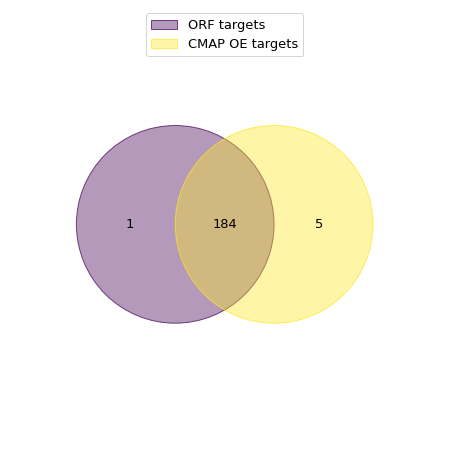

In [6]:
ax = venn(
    {"ORF targets": set(orf_targets), "CMAP OE targets": set(cmap_oe_targets)},
    legend_loc="upper center",
)

The only gene target for which no sequencing data is available is PSENEN.

In [7]:
cmap_inst_oe = cmap_inst_oe.loc[
    (cmap_inst_info["cell_iname"] == "U2OS")
    & (cmap_inst_info["cmap_name"].isin(orf_targets.union(set(["UnTrt"]))))
    & (cmap_inst_info["project_code"] == "TA")
    & (cmap_inst_info["qc_pass"] == 1)
]
cmap_inst_oe.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_itime,pert_time_unit,cell_mfc_name,pert_mfc_id,...,sample_id,pert_type,cell_iname,qc_pass,dyn_range,inv_level_10,build_name,failure_mode,project_code,cmap_name
517,b15,NaN,1.0,uL,1 uL,72.0,72 h,h,U2OS,BRDN0000459610,...,TA.OE005_U2OS_72H_X1_B15:I22,trt_oe,U2OS,1.0,11.17160,2994.0,NaN,NaN,TA,MAP3K7
692,b15,NaN,1.0,uL,1 uL,72.0,72 h,h,U2OS,BRDN0000464959,...,TA.OE005_U2OS_72H_X1_B15:N03,trt_oe,U2OS,1.0,8.05593,3601.0,NaN,NaN,TA,BMPR1B
694,b15,NaN,1.0,uL,1 uL,72.0,72 h,h,U2OS,BRDN0000410597,...,TA.OE005_U2OS_72H_X1_B15:C07,trt_oe,U2OS,1.0,10.32120,3406.0,NaN,NaN,TA,MAPK14
741,b18,NaN,1.0,uL,1 uL,72.0,72 h,h,U2OS,BRDN0000464899,...,TA.OE005_U2OS_72H_X2.A2_B18:B09,trt_oe,U2OS,1.0,10.84130,2255.0,NaN,NaN,TA,ARAF
784,b15,NaN,1.0,uL,1 uL,72.0,72 h,h,U2OS,BRDN0000407962,...,TA.OE005_U2OS_72H_X1_B15:M09,trt_oe,U2OS,1.0,10.97500,3737.0,NaN,NaN,TA,PIK3R1


In [8]:
np.unique(cmap_inst_oe.bead_batch)

array(['b15', 'b18'], dtype=object)

---

## 3. Analyze expression change upon overexpression.


### 3a. Preprocessing of the GEX data

We now read in the gene expression data to explore the change of gene expression upon overexpression of the different genes.

In [14]:
oe_gex_data = parse("../../data/gex/cmap/level3_beta_trt_oe_n131668x12328.gctx")
ctl_gex_data = parse("../../data/gex/cmap/level3_beta_ctl_n188708x12328.gctx")

We filter out any data not corresponding to a control setting or and overexpression setting of U2OS cells of the project "TA" and rename the genes using the respective HUGO symbols.

In [15]:
gex_data_df = oe_gex_data.data_df.join(ctl_gex_data.data_df)
gex_data_df = gex_data_df.loc[:, list(cmap_inst_oe["sample_id"])]

In [16]:
gene_info = pd.read_csv("../../data/gex/cmap/cmap_geneinfo_beta.txt", sep="\t")

In [17]:
gene_id_symbol_dict = dict(
    zip(gene_info.loc[:, "gene_id"].astype(str), gene_info.loc[:, "gene_symbol"])
)
gex_data_df = gex_data_df.rename(gene_id_symbol_dict)


We save the filtered data set for further analyses.

In [13]:
gex_data_df.to_csv("../../data/gex/cmap/cmap_u2os_ctl_oe_level3.csv")

<IPython.core.display.Javascript object>

Before we continue with those we quickly look at the overlap of the measured gene set with that of our current selected gene set that correspond to genes both covered in the scRNAseq data set and the human PPI that was pruned to remove low-confidence edges.

In [14]:
with open("../../data/other/ppi_nodes_confidence_pruned_scrna_coverage.csv") as f:
    ppi_nodes = set(f.read().split("\n")[:-1])
landmark_genes = set(
    gene_info.loc[gene_info["feature_space"] == "landmark", "gene_symbol"]
)
bin_genes = set(
    gene_info.loc[gene_info["feature_space"] == "best inferred", "gene_symbol"]
)

<IPython.core.display.Javascript object>

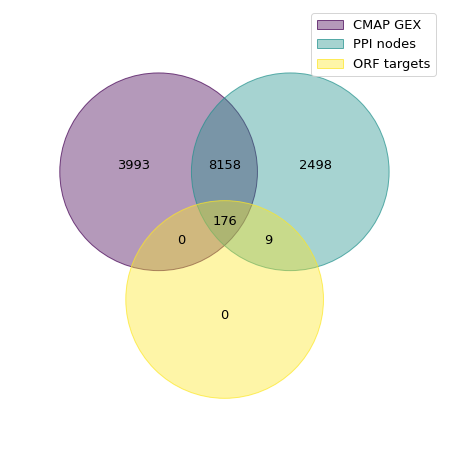

<IPython.core.display.Javascript object>

In [15]:
venn(
    {
        "CMAP GEX": set(gex_data_df.index),
        "PPI nodes": set(ppi_nodes),
        "ORF targets": orf_targets,
    },
)
plt.show()

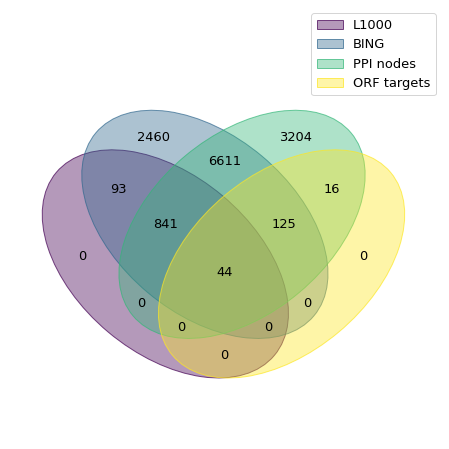

<IPython.core.display.Javascript object>

In [16]:
venn(
    {
        "L1000": landmark_genes,
        "BING": bin_genes.union(landmark_genes),
        "PPI nodes": set(ppi_nodes),
        "ORF targets": orf_targets,
    },
)
plt.show()

We find that 841/978 of the measured landmark genes are covered in our selected PPI network including 44 ORF targets. Additional 125 are among the best inferred genes (those for which the inferred expression was significantly higher correlated (pval < 0.05) with the measured expression of that gene compared to other gene expression profiles.

Those also include the 9 targets for which the morphological profiles as computed by the authors Rohban et al. 2017 showed the most significant enrichment of certain subpopulations upon overexpression: ARNTL, ATG5, BAX, CASP8, CCND1, CEBPA, DVL2, ERG and JUN. BAX, CCND1, CEBPA and JUN are also part of the L1000 gene set that was measured and not inferred in the CMAP data set. 

---

### 3b. Visualization of the CMAP data set

In the next step, we will use the CMAP data set and visualize the different perturbation settings in UMAP space.

In [17]:
gex_data_df = gex_data_df.transpose()
gex_data_df.head()

rid,NAT2,ADA,CDH2,AKT3,MED6,NAALAD2,NAALADL1,ACOT8,ABI1,GNPDA1,...,REC8,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,SCO2
cid,,,,,,,,,,,,,,,,,,,,,
TA.OE005_U2OS_72H_X1_B15:I22,3.96670,6.58910,8.41550,9.1009,9.2187,6.16010,5.74730,8.508900,5.3787,9.5198,...,6.08685,12.0442,5.84740,9.0336,0.0000,4.7852,6.00635,6.0390,8.3354,7.278000
TA.OE005_U2OS_72H_X1_B15:N03,5.14570,7.20080,8.66900,9.1791,9.5755,5.16820,6.22990,7.666501,4.8636,9.4814,...,4.96920,11.2995,5.19670,8.8855,2.0564,4.4527,5.12945,6.0506,8.9166,8.327101
TA.OE005_U2OS_72H_X1_B15:C07,4.95775,6.53235,10.51650,9.2408,10.0208,5.85355,6.18830,7.318900,5.6846,9.4506,...,5.10745,11.7192,5.56515,9.1158,0.3760,5.1427,7.26800,6.1781,8.2798,8.162100
TA.OE005_U2OS_72H_X2.A2_B18:B09,5.98160,8.22930,7.26560,7.3707,8.4014,6.18775,5.88150,7.822200,6.2002,8.7578,...,4.99730,10.7239,6.69500,9.4358,2.1771,4.4281,6.05060,6.3374,8.6131,9.009900
TA.OE005_U2OS_72H_X1_B15:M09,4.87760,8.66460,7.59075,8.5960,10.0978,5.33270,5.91515,7.797900,5.9032,9.6568,...,4.98620,11.7635,7.80960,9.4488,2.9490,4.3843,5.34920,5.3547,8.0183,7.920300


<IPython.core.display.Javascript object>

In [18]:
cmap_inst_oe.index = cmap_inst_oe.sample_id
targets = cmap_inst_oe.loc[gex_data_df.index, "cmap_name"]
bead_batches = cmap_inst_oe.loc[gex_data_df.index, "bead_batch"]

<IPython.core.display.Javascript object>

Before we reduce the dimensions using UMAP to plot the sample space, we first log1p transform the data and scale each row to a range of 0-1 to make the individual profiles more comparable following the pipeline suggested in Belyaeva et al. (2021).

In [19]:
scaled_gex_data = np.log1p(gex_data_df)
scaled_gex_data = (
    scaled_gex_data.transpose() - scaled_gex_data.transpose().min(axis=0)
) / (scaled_gex_data.transpose().max(axis=0) - scaled_gex_data.transpose().min(axis=0))
scaled_gex_data_df = scaled_gex_data.transpose()
scaled_gex_data_df.describe()

rid,NAT2,ADA,CDH2,AKT3,MED6,NAALAD2,NAALADL1,ACOT8,ABI1,GNPDA1,...,REC8,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,SCO2
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,...,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,0.686374,0.765570,0.788078,0.799442,0.840006,0.693165,0.695977,0.783262,0.680148,0.840564,...,0.637450,0.900797,0.707036,0.821992,0.360035,0.605165,0.716140,0.704401,0.806464,0.827700
std,0.038485,0.036853,0.050356,0.026749,0.016865,0.022764,0.017590,0.013639,0.028408,0.014626,...,0.043475,0.015362,0.047082,0.017337,0.158949,0.026690,0.040425,0.016245,0.017674,0.026036
min,0.578072,0.591245,0.577032,0.694527,0.760876,0.592994,0.619387,0.692934,0.522900,0.701509,...,0.471267,0.854163,0.554509,0.733308,0.000000,0.528230,0.551950,0.647633,0.726588,0.628411
25%,0.656973,0.744995,0.763851,0.784451,0.829722,0.680906,0.685433,0.775962,0.663400,0.832738,...,0.610792,0.890547,0.675700,0.811997,0.268220,0.588200,0.693486,0.694538,0.795412,0.813500
50%,0.688321,0.770209,0.796362,0.798214,0.839945,0.694094,0.695516,0.784959,0.681285,0.840732,...,0.638730,0.900931,0.709069,0.823247,0.391850,0.606580,0.722066,0.704353,0.807395,0.829431
75%,0.714555,0.791231,0.823348,0.815142,0.851454,0.709198,0.707146,0.792719,0.699290,0.848189,...,0.664969,0.910899,0.734720,0.832476,0.471640,0.622610,0.744945,0.713434,0.817998,0.844580
max,0.806118,0.865726,0.929958,0.965556,0.882555,0.774375,0.750126,0.817382,0.749490,0.898353,...,0.863136,0.946497,0.858243,0.885369,0.868193,0.742907,0.801683,0.762201,0.864366,0.896985


<IPython.core.display.Javascript object>

Now, we fit a UMAP using a) only the L1000 genes and b) the BING gene set.

We will however, do that for each bead batch individually as there are very strong batch effects.

#### L1000 gene set

In [20]:
l1000_b15_data = np.array(scaled_gex_data_df.loc[:, landmark_genes])[
    bead_batches == "b15"
]
l1000_b15_umapper = umap.UMAP(random_state=seed).fit(l1000_b15_data)
l1000_b15_embs = pd.DataFrame(
    l1000_b15_umapper.transform(l1000_b15_data),
    columns=["umap_c1", "umap_c2"],
)
l1000_b15_embs.loc[:, "target"] = np.array(targets[bead_batches == "b15"])
l1000_b15_embs.loc[:, "bead_batch"] = "b15"

<IPython.core.display.Javascript object>

In [21]:
l1000_b18_data = np.array(scaled_gex_data_df.loc[:, landmark_genes])[
    bead_batches == "b18"
]
l1000_b18_umapper = umap.UMAP(random_state=seed).fit(l1000_b18_data)
l1000_b18_embs = pd.DataFrame(
    l1000_b18_umapper.transform(l1000_b18_data),
    columns=["umap_c1", "umap_c2"],
)
l1000_b18_embs["target"] = np.array(targets[bead_batches == "b18"])
l1000_b18_embs["bead_batch"] = "b18"

<IPython.core.display.Javascript object>

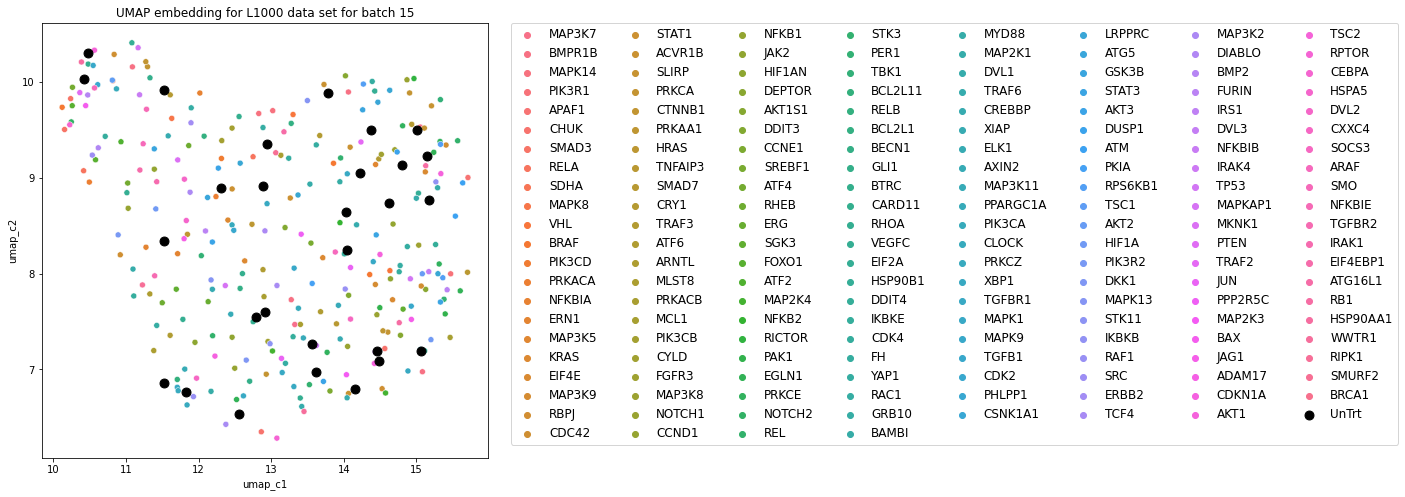

<IPython.core.display.Javascript object>

In [22]:
fig = plt.figure(figsize=[8, 8])
pert_plot = sns.scatterplot(
    data=l1000_b15_embs.loc[(l1000_b15_embs["target"] != "UnTrt")],
    x="umap_c1",
    y="umap_c2",
    hue="target",
)
ctrl_plot = plt.scatter(
    x=l1000_b15_embs.loc[l1000_b15_embs["target"] == "UnTrt", "umap_c1"],
    y=l1000_b15_embs.loc[l1000_b15_embs["target"] == "UnTrt", "umap_c2"],
    s=80,
    c="k",
    label="UnTrt",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=8, prop={"size": 12})
plt.title("UMAP embedding for L1000 data set for batch 15")
plt.show()
plt.close()

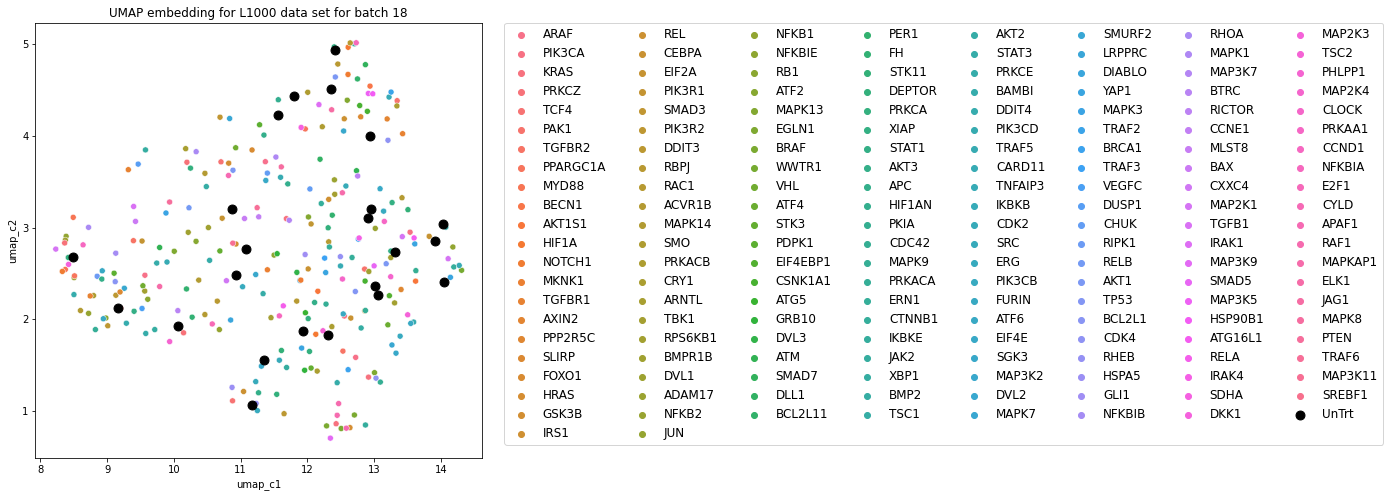

<IPython.core.display.Javascript object>

In [23]:
fig = plt.figure(figsize=[8, 8])
pert_plot = sns.scatterplot(
    data=l1000_b18_embs.loc[(l1000_b18_embs["target"] != "UnTrt")],
    x="umap_c1",
    y="umap_c2",
    hue="target",
)
ctrl_plot = plt.scatter(
    x=l1000_b18_embs.loc[l1000_b18_embs["target"] == "UnTrt", "umap_c1"],
    y=l1000_b18_embs.loc[l1000_b18_embs["target"] == "UnTrt", "umap_c2"],
    s=80,
    c="k",
    label="UnTrt",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=8, prop={"size": 12})
plt.title("UMAP embedding for L1000 data set for batch 18")
plt.show()
plt.close()

---

#### BING set

In [24]:
bing_b15_data = np.array(scaled_gex_data_df.loc[:, bin_genes.union(landmark_genes)])[
    bead_batches == "b15"
]

bing_b15_umapper = umap.UMAP(random_state=seed).fit(bing_b15_data)
bing_b15_embs = pd.DataFrame(
    bing_b15_umapper.transform(bing_b15_data),
    columns=["umap_c1", "umap_c2"],
)
bing_b15_embs.loc[:, "target"] = np.array(targets[bead_batches == "b15"])
bing_b15_embs.loc[:, "bead_batch"] = "b15"

<IPython.core.display.Javascript object>

In [36]:
bing_b18_data = np.array(scaled_gex_data_df.loc[:, bin_genes.union(landmark_genes)])[
    bead_batches == "b18"
]
bing_b18_umapper = umap.UMAP(random_state=seed).fit(bing_b18_data)
bing_b18_embs = pd.DataFrame(
    bing_b18_umapper.transform(bing_b18_data),
    columns=["umap_c1", "umap_c2"],
)
bing_b18_embs["target"] = np.array(targets[bead_batches == "b18"])
bing_b18_embs["bead_batch"] = "b18"

<IPython.core.display.Javascript object>

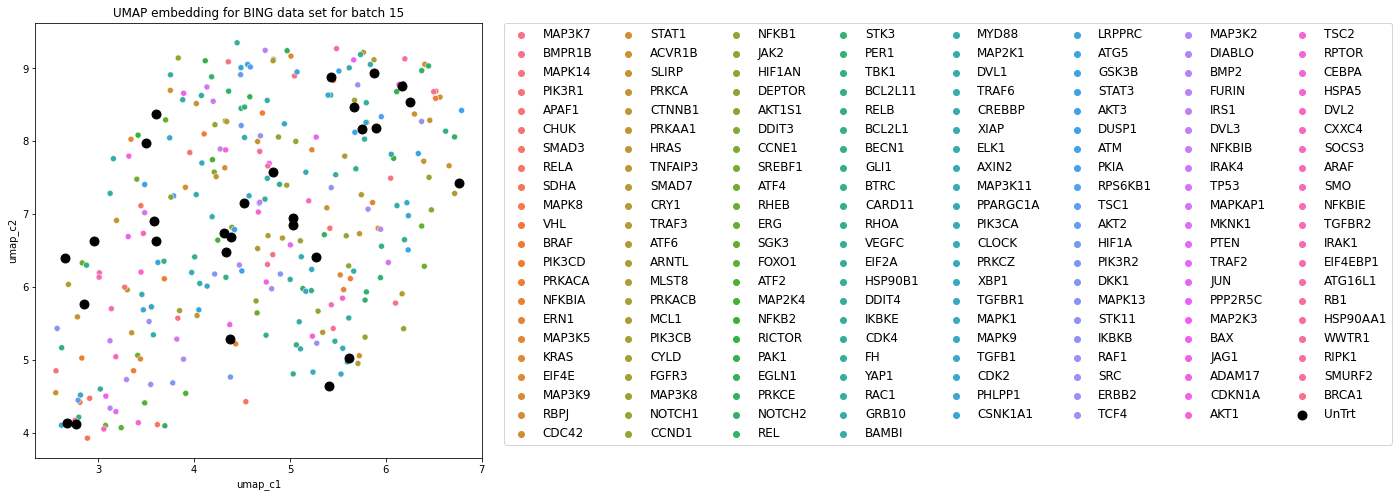

<IPython.core.display.Javascript object>

In [26]:
fig = plt.figure(figsize=[8, 8])
pert_plot = sns.scatterplot(
    data=bing_b15_embs.loc[(bing_b15_embs["target"] != "UnTrt")],
    x="umap_c1",
    y="umap_c2",
    hue="target",
)
ctrl_plot = plt.scatter(
    x=bing_b15_embs.loc[bing_b15_embs["target"] == "UnTrt", "umap_c1"],
    y=bing_b15_embs.loc[bing_b15_embs["target"] == "UnTrt", "umap_c2"],
    s=80,
    c="k",
    label="UnTrt",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=8, prop={"size": 12})
plt.title("UMAP embedding for BING data set for batch 15")
plt.show()
plt.close()

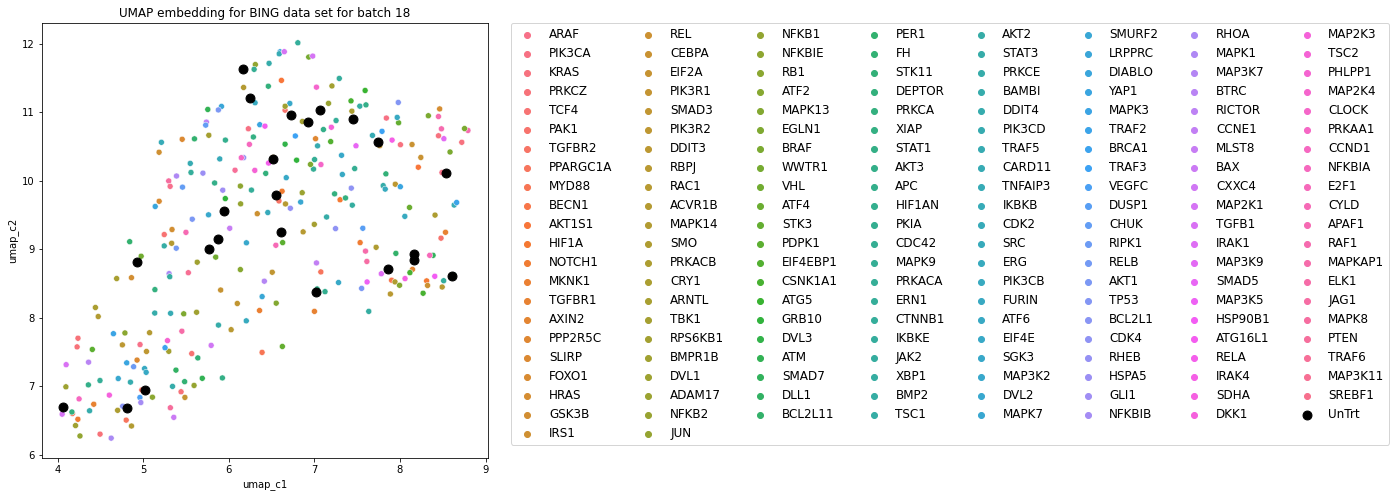

<IPython.core.display.Javascript object>

In [37]:
fig = plt.figure(figsize=[8, 8])
pert_plot = sns.scatterplot(
    data=bing_b18_embs.loc[(bing_b18_embs["target"] != "UnTrt")],
    x="umap_c1",
    y="umap_c2",
    hue="target",
)
ctrl_plot = plt.scatter(
    x=bing_b18_embs.loc[bing_b18_embs["target"] == "UnTrt", "umap_c1"],
    y=bing_b18_embs.loc[bing_b18_embs["target"] == "UnTrt", "umap_c2"],
    s=80,
    c="k",
    label="UnTrt",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=8, prop={"size": 12})
plt.title("UMAP embedding for BING data set for batch 18")
plt.show()
plt.close()

Overall the embeddings look relatively similar when looking at each batch individually. Importantly, we see the control condition to be as heterogenous as the treatment condition.

---

## 4. Gene expression analyses (Level 5)

Due to the large differences between the batches we will now have a look at the gene signatures from the overexpression settings obtained from the maximal level of postprocessing i.e. the level 5 of the connectivity map.

### 4a. GEX preprocessing

In [9]:
l5_oe_gex_data = parse("../../data/gex/cmap/level5_beta_trt_oe_n34171x12328.gctx")
l5_ctl_gex_data = parse("../../data/gex/cmap/level5_beta_ctl_n58022x12328.gctx")

In [10]:
cmap_siginfo = pd.read_csv("../../data/gex/cmap/siginfo_beta.txt", sep="\t")
cmap_siginfo.head()

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,sig_id,pert_type,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_ncs_exemplar
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,MET001_N8_XH:BRD-U44432129:100:336,trt_cp,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,ABY001_A549_XH:BRD-K81418486:10:3,trt_cp,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,ABY001_HT29_XH:BRD-K70511574:2.5:24,trt_cp,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,LTC002_HME1_3H:BRD-K81418486:10,trt_cp,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,ABY001_H1975_XH:BRD-A61304759:10:3,trt_cp,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0


In [11]:
cmap_siginfo_oe = cmap_siginfo.loc[
    (cmap_siginfo["project_code"] == "TA")
    & (cmap_siginfo["cell_iname"] == "U2OS")
    & (cmap_siginfo["qc_pass"] == 1)
]
cmap_siginfo_oe = cmap_siginfo_oe.loc[
    cmap_siginfo["pert_type"].isin(["ctl_untrt", "trt_oe"])
]
cmap_siginfo_oe = cmap_siginfo_oe.loc[
    cmap_siginfo_oe["cmap_name"].isin(list(orf_targets) + ["UnTrt"])
]
cmap_siginfo_oe.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,sig_id,pert_type,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_ncs_exemplar
76127,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464889,...,TA.OE005_U2OS_72H:BRDN0000464889:1,trt_oe,U2OS,O02,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:O02|TA.OE005_U2OS_72H...,NaN,TA,SMAD3,1
76310,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000459386,...,TA.OE005_U2OS_72H:BRDN0000459386:1,trt_oe,U2OS,G04,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:G04|TA.OE005_U2OS_72H...,NaN,TA,PIK3CA,1
76361,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000410175,...,TA.OE005_U2OS_72H:BRDN0000410175:1,trt_oe,U2OS,I15,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:I15|TA.OE005_U2OS_72H...,NaN,TA,SGK3,1
76415,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000464950,...,TA.OE005_U2OS_72H:BRDN0000464950:1,trt_oe,U2OS,L03,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:L03|TA.OE005_U2OS_72H...,NaN,TA,TSC1,1
76416,b15,NaN,1.0,uL,1 uL,72 h,72.0,h,U2OS,BRDN0000411728,...,TA.OE005_U2OS_72H:BRDN0000411728:1,trt_oe,U2OS,I09,TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....,TA.OE005_U2OS_72H_X1_B15:I09|TA.OE005_U2OS_72H...,NaN,TA,IKBKE,1


In [ ]:
cm

In [247]:
cmap_oe_targets = list(cmap_siginfo_oe["cmap_name"])

<IPython.core.display.Javascript object>

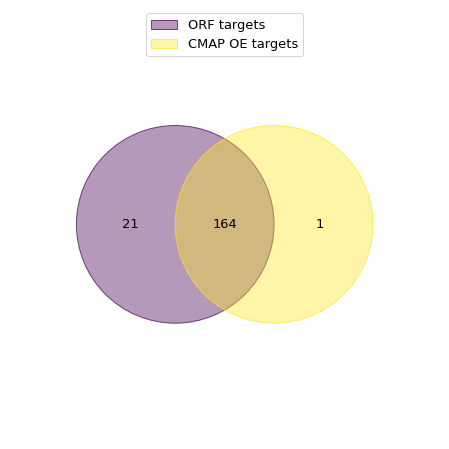

<IPython.core.display.Javascript object>

In [248]:
ax = venn(
    {"ORF targets": set(orf_targets), "CMAP OE targets": set(cmap_oe_targets)},
    legend_loc="upper center",
)

We see that 164 of 185 ORF targets are covered in the level 5 data set for each there exist at least one signature (depending on how many different alleles were targeted). We now focus on those signatures.

In [18]:
l5_gex_data_df = l5_oe_gex_data.data_df.join(l5_ctl_gex_data.data_df)
l5_gex_data_df = l5_gex_data_df.loc[:, list(cmap_siginfo_oe["sig_id"])]
l5_gex_data_df = l5_gex_data_df.rename(gene_id_symbol_dict)

In [19]:
l5_gex_data_df = l5_gex_data_df.transpose()
l5_gex_data_df.head()

rid,NAT2,ADA,CDH2,AKT3,MED6,NAALAD2,NAALADL1,ACOT8,ABI1,GNPDA1,...,REC8,HNRNPDL,DMTF1,PPP4R1,CDH1,SLC12A6,PTBP3,KCNE2,DGCR2,SCO2
cid,,,,,,,,,,,,,,,,,,,,,
TA.OE005_U2OS_72H:BRDN0000464889:1,0.19080,0.50560,-0.93515,0.89610,-0.81805,0.11990,0.89470,-0.57760,-0.62400,0.28655,...,0.11615,-0.58545,-1.22275,0.25765,0.04380,0.32285,-0.44800,1.12075,0.74645,-0.01155
TA.OE005_U2OS_72H:BRDN0000459386:1,0.56635,-1.66955,0.14820,0.49975,-2.46345,-0.25570,1.71565,0.03935,-0.38475,0.38405,...,1.30150,-0.25405,-0.21355,0.94500,0.98570,1.07445,-0.64150,0.45585,-0.04650,0.95830
TA.OE005_U2OS_72H:BRDN0000410175:1,-1.25925,0.36425,0.83090,1.05580,-0.44635,0.12945,-0.06770,1.41495,-1.07905,0.26805,...,0.45210,0.23180,-0.60970,-0.27025,-0.18905,-0.22015,0.17305,-0.56900,-0.85030,-0.41565
TA.OE005_U2OS_72H:BRDN0000464950:1,1.25560,-0.71055,0.11175,-0.18500,0.37175,0.23640,0.35615,0.21925,-0.12245,-0.30850,...,0.44560,-1.22925,-0.46810,0.37650,-0.57205,1.24500,-0.58500,1.18870,0.50000,0.57325
TA.OE005_U2OS_72H:BRDN0000411728:1,-1.18205,0.33590,0.99960,-0.49725,-0.75755,-0.68780,-0.46005,-0.82775,-0.38880,0.85410,...,-0.59705,0.84330,0.81930,0.08810,0.73240,0.10705,0.82120,-0.86055,-0.82505,-0.55240


In [32]:
from scipy.stats import spearmanr

spearmanr(l5_gex_data_df.loc[:, "CDKN1A"], l5_gex_data_df.loc[:, "E2F1"])

SpearmanrResult(correlation=-0.2173631581194837, pvalue=0.00047255864862560194)

In [255]:
l5_data = l5_gex_data_df.loc[:, landmark_genes].copy()
l5_data["target"] = np.array(cmap_oe_targets)
l5_data.to_csv("../../data/gex/cmap/filtered_l5_data_u2os.csv")

<IPython.core.display.Javascript object>

---

### 4b. Visualization of the data

We will plot the data using UMAP for the L1000 gene set and the BING gene set.

In [109]:
l1000_l5_data = np.array(l5_gex_data_df.loc[:, landmark_genes])
l1000_l5_umapper = umap.UMAP(random_state=seed).fit(l1000_l5_data)
l1000_l5_embs = pd.DataFrame(
    l1000_l5_umapper.transform(l1000_l5_data),
    columns=["umap_c1", "umap_c2"],
)
l1000_l5_embs.loc[:, "target"] = np.array(cmap_oe_targets)

<IPython.core.display.Javascript object>

In [63]:
bing_l5_data = np.array(l5_gex_data_df.loc[:, bin_genes.union(landmark_genes)])
bing_l5_umapper = umap.UMAP(random_state=seed).fit(bing_l5_data)
bing_l5_embs = pd.DataFrame(
    bing_l5_umapper.transform(bing_l5_data),
    columns=["umap_c1", "umap_c2"],
)
bing_l5_embs.loc[:, "target"] = np.array(cmap_oe_targets)

<IPython.core.display.Javascript object>

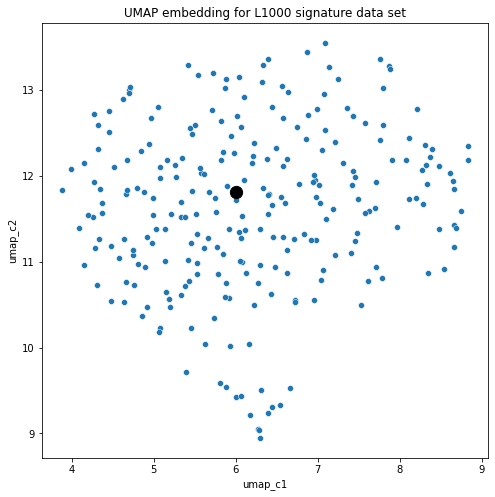

<IPython.core.display.Javascript object>

In [250]:
fig = plt.figure(figsize=[8, 8])
pert_plot = sns.scatterplot(
    data=l1000_l5_embs.loc[(l1000_l5_embs["target"] != "UnTrt")],
    x="umap_c1",
    y="umap_c2",
    # hue="target",
)
ctrl_plot = plt.scatter(
    x=l1000_l5_embs.loc[l1000_l5_embs["target"] == "UnTrt", "umap_c1"],
    y=l1000_l5_embs.loc[l1000_l5_embs["target"] == "UnTrt", "umap_c2"],
    s=150,
    c="k",
    label="UnTrt",
)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=8, prop={"size": 12})
plt.title("UMAP embedding for L1000 signature data set")
plt.show()
plt.close()

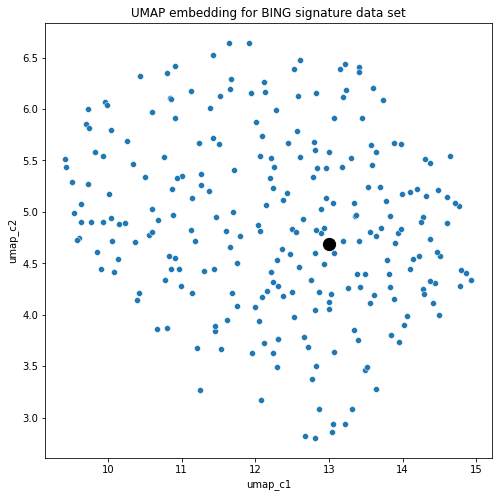

<IPython.core.display.Javascript object>

In [90]:
fig = plt.figure(figsize=[8, 8])
pert_plot = sns.scatterplot(
    data=bing_l5_embs.loc[(bing_l5_embs["target"] != "UnTrt")],
    x="umap_c1",
    y="umap_c2",
    # hue="target",
)
ctrl_plot = plt.scatter(
    x=bing_l5_embs.loc[bing_l5_embs["target"] == "UnTrt", "umap_c1"],
    y=bing_l5_embs.loc[bing_l5_embs["target"] == "UnTrt", "umap_c2"],
    s=150,
    c="k",
    label="UnTrt",
)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, ncol=8, prop={"size": 12})
plt.title("UMAP embedding for BING signature data set")
plt.show()
plt.close()

---

### 4c. Clustering of the gene signatures

To get a better understanding of which perturbations lead to similar functional changes, we will perform agglomerative clustering of the respective signatures for the L1000 gene space. To reduce the dimensionality, we will first run PCA on the signature set.

In [206]:
pca = PCA(random_state=1234)
sc = StandardScaler()

<IPython.core.display.Javascript object>

In [207]:
scaled_l1000_l5_data = sc.fit_transform(l1000_l5_data)
pc_embs_l1000_l5 = pca.fit_transform(scaled_l1000_l5_data)

<IPython.core.display.Javascript object>

Let us look at the scree plot to find an appropriate cutoff for the number of dimensions to keep.

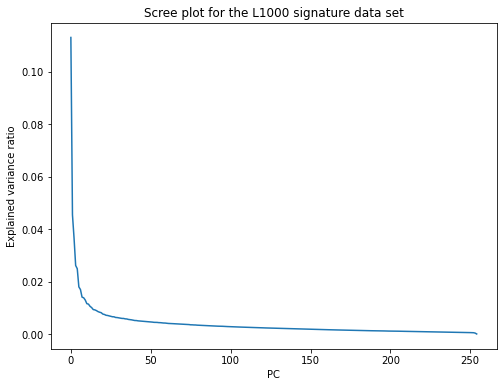

<IPython.core.display.Javascript object>

In [208]:
fig = plt.figure(figsize=[8, 6])
plt.plot(list(range(255)), pca.explained_variance_ratio_)
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot for the L1000 signature data set")
plt.show()
plt.close()

While the first principal component explains roughly 11% of the total variation in the data set also the other PCs carry important information. In fact to explain 80% of the total variation, we would need to use the first 111 PCs. This can be explained by the fact that the signatures of the L1000 genes are only very weakly correlated.

<AxesSubplot:>

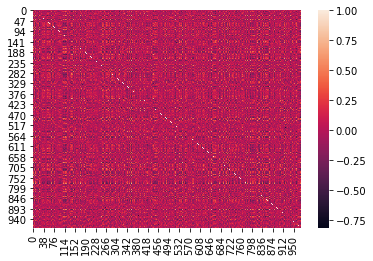

<IPython.core.display.Javascript object>

In [209]:
sns.heatmap(pd.DataFrame(scaled_l1000_l5_data).corr())

Thus, we will use the whole set of the 974 genes. Using agglomerative clustering does not provide well interpretable picture.

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


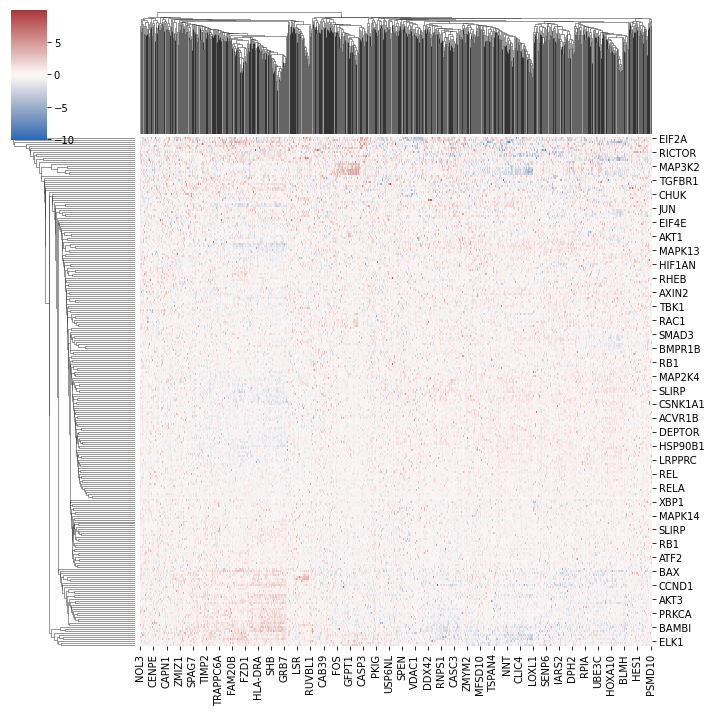

<IPython.core.display.Javascript object>

In [210]:
sns.clustermap(
    pd.DataFrame(scaled_l1000_l5_data, index=cmap_oe_targets, columns=landmark_genes),
    z_score=1,
    figsize=[10, 10],
    cmap="vlag",
)
plt.show()

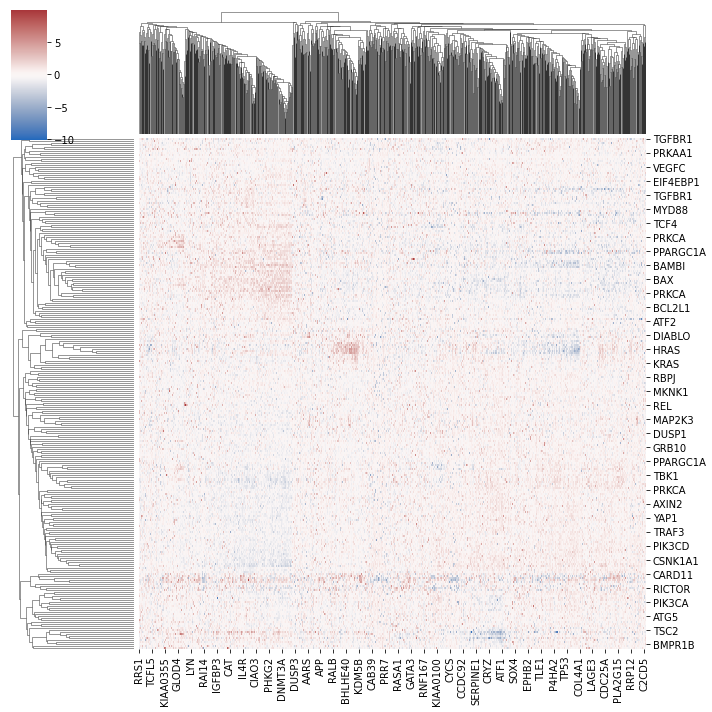

<IPython.core.display.Javascript object>

In [238]:
sns.clustermap(
    pd.DataFrame(scaled_l1000_l5_data, index=cmap_oe_targets, columns=landmark_genes),
    z_score=1,
    figsize=[10, 10],
    cmap="vlag",
    metric="cosine",
)
plt.show()

Alternative approach: UMAP (30 dimensions) HDBSCAN.

In [231]:
umap_embs_l5_l1000 = umap.UMAP(random_state=seed, n_components=30).fit_transform(
    scaled_l1000_l5_data
)

<IPython.core.display.Javascript object>

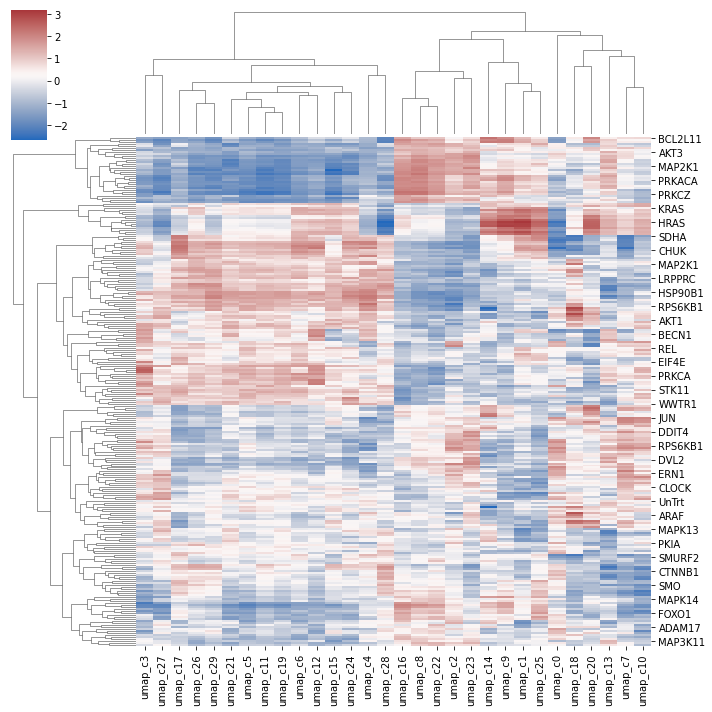

<IPython.core.display.Javascript object>

In [237]:
sns.clustermap(
    pd.DataFrame(
        umap_embs_l5_l1000,
        index=cmap_oe_targets,
        columns=["umap_c{}".format(i) for i in range(30)],
    ),
    z_score=1,
    figsize=[10, 10],
    cmap="vlag",
    metric="euclidean",
)
plt.show()